In [1]:
import ctypes
import os
import sys
import pygmo as pg
from pygmo import *
import numpy as np
import sys  
sys.path.insert(0, 'Schwefel_Problem/')
sys.path.insert(1, 'Shifted_Ackley/')
sys.path.insert(2, 'Shifted_Griewank/')
sys.path.insert(3, 'Shifted_Rastrigin/')
sys.path.insert(4, 'Shifted_Rosenbrock/')
sys.path.insert(5, 'Shifted_Sphere/')
sys.path.insert(6, 'cec08/')
import importnb

# CEC 2008
## Algorithm Used

All the six problems are single objective optimization problems. First two problems are unimodal and the rest are all multimodal. We are optimizing all of them for 50 and 500 dimensions which makes all of them high dimensional optimization problems. All the problems are continuous optimization problems. Four out of the six problems are multi-modal which means that we need to employ global search algorithms for finding their global optima. Further, we will need stochastic algorithms or metaheuristic algorithms for solving these multi-modal global optimization problems. All these characteristics make them suitable for metaheuristics population based algorithms like **Particle Swarm Optimization**. PSO swarm tries to emulate the success of neighbouring particles and their own. The collective behaviour helps in discovering optimal regions of a high dimensional space. It is therefore well suited for these problems.   


## Parameters

**eta1** is the cognitive component impacting the particle velocity. It reflects how much confidence the particle has in itself. It also reflects the exploitation component of the particle velocity. This component helps in finding the optima.

**eta2** is the social component impacting the particle velocity. It determines how a particle is affected by its neighbours or other particles in the swarm. It also reflects the exploration component of the particle velocity. This component allows the search to escape local optima and reach a global minima. It increaes the diversity of solution. 

**neighb_type** defines the swarm topology which in this case has been set to star topology resulting in a gbest algorithm i.e. the global best position of the swarm is used by each particle as the social best.

**variant** used in this problem is 'canonical with constriction factor'. This variant is used to balance the exploration and exploitation tradeoff. With constriction coefficient in range of [0,1] velocity is reduced at each time step. 

**omega** is the constriction factor used in this variant. It reflects the inertia of of the particle.

**memory** parameter is used to control whether the best positions of all particles from the current iteration is used or from personal best positions of all particles over all iterations.

**max velocity** This is maximum velocity coefficient for the box-bounds width in [0,1]


## Parallel Execution Architecture
We used simple single processing architecture initally. It was time consuming but gave out logs with details, which helped in fine tuning the parameters. Later on we switched to use an archipelago of islands to parallelize the algorithm execution and thereby speed up the computation especially for high dimensional space with 500 dimensions. We obtained significant performance gains using the parallel archipelago based architecture. e.g. in some of the problems we reduced time consumed from roughly 50 mins to 5 minutes for n=25 runs. 

## No Python C++
We also used No python C++ execution for function evaluations to get further performance gains. It was an optimization for code written in python.


In [2]:
from Shifted_Sphere import Shifted_Sphere
from Schwefel_Problem import Schwefel_Problem
from Shifted_Ackley import Shifted_Ackley
from Shifted_Griewank import Shifted_Griewank
from Shifted_Rastrigin import Shifted_Rastrigin
from Shifted_Rosenbrock import Shifted_Rosenbrock

#set the architecture as parallel 
architecture = 'Parallel'

ntype = 1

def Run_Shifted_Sphere(params):
    prob = pg.problem(Shifted_Sphere(params['dim']))
    accuracy = evaluate_Problem(prob,params['dim'], params['num_gen'], params['population_size'], params['eta1'],params['eta2'],params['max_vel'],params['omega'],-450)
    return accuracy
def Run_Schwefel_Problem(params):
    prob = pg.problem(Schwefel_Problem(params['dim']))
    accuracy = evaluate_Problem(prob, params['dim'],params['num_gen'], params['population_size'], params['eta1'],params['eta2'],params['max_vel'],params['omega'],-450)
    return accuracy
def Run_Ackley(params):
    prob = pg.problem(Shifted_Ackley(params['dim']))
    accuracy = evaluate_Problem(prob, params['dim'],params['num_gen'], params['population_size'], params['eta1'],params['eta2'],params['max_vel'],params['omega'],-140)
    return accuracy
def Run_Griewank(params):
    prob = pg.problem(Shifted_Griewank(params['dim']))
    accuracy = evaluate_Problem(prob, params['dim'],params['num_gen'], params['population_size'], params['eta1'],params['eta2'],params['max_vel'],params['omega'],-180)
    return accuracy
def Run_Rastrigin(params):
    prob = pg.problem(Shifted_Rastrigin(params['dim']))
    accuracy = evaluate_Problem(prob, params['dim'],params['num_gen'], params['population_size'], params['eta1'],params['eta2'],params['max_vel'],params['omega'],-330)
    return accuracy
def Run_Rosenbrock(params):
    prob = pg.problem(Shifted_Rosenbrock(params['dim']))
    accuracy = evaluate_Problem(prob, params['dim'],params['num_gen'], params['population_size'], params['eta1'],params['eta2'],params['max_vel'],params['omega'],390)
    return accuracy

In [3]:
import datetime
import matplotlib.pyplot as plt
def evaluate_Problem_Using_Parallel_Architecture(prob,dim, num_gen,population_size, eta1,eta2,max_vel,omega, optima):
    print(prob)
    logs = []
    fitness_value = []
    generations = []
    Bestchamp = np.abs(optima*100)
    uda = pg.pso(gen=num_gen, omega=omega, eta1=eta1, eta2=eta2, max_vel=max_vel, variant=5, neighb_type=ntype,neighb_param = 4, memory=True,seed=1)              
    algo = pg.algorithm(uda)
    algo.set_verbosity(100)
    archi = pg.archipelago(n=25,algo=algo, prob=prob, pop_size=population_size)
    start_time = datetime.datetime.now()
    archi.evolve() 
    archi.wait()
    print(algo.extract(type(uda)).get_log())        
    for i, island in enumerate(archi): # iterate through islands
        algois = island.get_algorithm()      # get algorithm from island
        popis = island.get_population()
        if(popis.get_f()[popis.best_idx()][0] < Bestchamp):
            Bestchamp = popis.get_f()[popis.best_idx()][0]
            logs = algois.extract(type(uda)).get_log()
        
    for i in range(len(logs)):
        fitness_value.append(logs[i][2])
        generations.append(logs[i][1])

    end_time = datetime.datetime.now()
    span = end_time-start_time
    plt.plot(generations, fitness_value) 
    # naming the x axis 
    plt.xlabel('Function Evals') 
    # naming the y axis 
    plt.ylabel('Fitness Value') 
    plt.show() 
    
    champions = np.sort(np.concatenate(archi.get_champions_f(), axis=0))
    print("Best minimas of each run:")
    print(champions)
    print(", ".join(["Params:",str(dim) , str(num_gen), str(population_size), str(omega), str(eta1), str(eta2), str(max_vel), "5", "1", "True", "1"]))
    print(" ".join(["Time span:",str(span.total_seconds())]))
    print('Best loss' + str(-(optima-champions[0])))

In [4]:
def evaluate_Problem(prob,dim, num_gen, population_size, eta1, eta2, max_vel, omega,optima):
    if(architecture == 'Parallel') :
        evaluate_Problem_Using_Parallel_Architecture(prob,dim,num_gen,population_size,eta1,eta2,max_vel,omega,optima)
    else:
        evaluate_Problem_Without_Parallel_Architecture(prob,dim,num_gen,population_size,eta1,eta2,max_vel,omega,optima)

In [5]:

def evaluate_Problem_Without_Parallel_Architecture(prob,dim, num_gen, population_size, eta1, eta2, max_vel, omega,optima):
    print(prob) 

    champion = []
    fitness_value = []
    generations = []
    Bestchamp = 0
    uda = pg.pso(gen=num_gen, omega=omega, eta1=eta1, eta2=eta2, max_vel=max_vel, variant=5,  neighb_type=ntype, neighb_param = 4, memory=True,seed=1)              
    start_time = datetime.datetime.now()
    for i in range(25):    
        algo = pg.algorithm(uda)
        algo.set_verbosity(100)
        pop = pg.population(prob,population_size)
        pop = algo.evolve(pop)

        if(pop.get_f()[pop.best_idx()][0] < Bestchamp):
            Bestchamp = pop.get_f()[pop.best_idx()][0]
            logs = algo.extract(type(uda)).get_log()
        champion.append( pop.get_f()[pop.best_idx()][0])
        
    for i in range(len(logs)):
        fitness_value.append(logs[i][2])
        generations.append(logs[i][1])
    
    plt.plot(generations, fitness_value) 
    # naming the x axis 
    plt.xlabel('Function Evals') 
    # naming the y axis 
    plt.ylabel('Fitness Value') 
    plt.show() 
    
    end_time = datetime.datetime.now()
    span = end_time-start_time
    champions = np.sort(champion)
    print("Best minimas of each run:")
    print(champions)
    print(", ".join(["Params:",str(dim) , str(num_gen), str(population_size), str(omega), str(eta1), str(eta2), str(max_vel), "5", "1", "True", "1"]))
    print(" ".join(["Time span:",str(span.total_seconds())]))
    print('Best loss' + str(-(optima-champions[0])))

# Shifted Sphere

Shifted Sphere is a unimodal function which means that it has a single minima which will be its local and global minima

### Choice of parameters
In case of Shifted Sphere problem a large value of cognitive component as compared to the social component will be efficient as it will lead to intensification or exploitation for each particle and pulling it towards its best position. It causes the particles to move towards the optima which is a good strategy for a unimodal problem. We are using gbest as neighbourhood type so that causes the particle to converge faster. Max velocity and inertia are both set to their default values of 0.5 and 0.7298 respectively. 
    parameters = {   
        'eta1':2.5,
        'eta2': 1.55,
        'max_vel': 0.5,
        'omega' : 0.7298,
    }
    
### Results Obtained
#### 50 dimensions
##### Parameters
We set 'population_size' or the swarm size to 50 which leads to reasonable results. The 'num_gen' or number of ierations is set to 5000 so that we reach the MAX_FES limit.
##### Results
For 50 dimensions we reached the function minimum of -450 which is the actual optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 250,000
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 250,000 FES was 5.93 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges easily with lots of function evals left from Max_FES. Please see the output below for the graph.
#### 500 dimensions
##### Parameters
We set 'population_size' to 100 and 'num_gen' to 25000
##### Results
For 500 dimensions we reached the function minimum of -450 which is the actual optima. There are lots of function evals left from Max_FES. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 2.5 million
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 2.5 million FES was 253 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges with more function evals as compared to 50 dimensions. Please see the output below for the graph.


In [6]:
params_sphere_50 ={'eta1':2.5,
        'eta2': 1.55,
        'max_vel': 0.5,
        'omega' : 0.7298,
        'dim' : 50,
        'population_size': 50,
        'num_gen' : 5000
    }

Problem name: Shifted Sphere CEC08
	C++ class name: pybind11::object

	Global dimension:			50
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-100, -100, -100, -100, -100, ... ]
	Upper bounds: [100, 100, 100, 100, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 50
[]


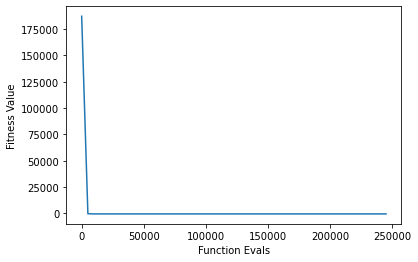

Best minimas of each run:
[-450. -450. -450. -450. -450. -450. -450. -450. -450. -450. -450. -450.
 -450. -450. -450. -450. -450. -450. -450. -450. -450. -450. -450. -450.
 -450.]
Params:, 50, 5000, 50, 0.7298, 2.5, 1.55, 0.5, 5, 1, True, 1
Time span: 7.905445
Best loss5.684341886080802e-14


In [7]:
Run_Shifted_Sphere(params_sphere_50)

In [8]:
params_sphere_500 ={'eta1':2.5,
        'eta2': 1.55,
        'max_vel': 0.5,
        'omega' : 0.7298,
        'dim' : 500,
        'population_size': 100,
        'num_gen' : 25000
    }


Problem name: Shifted Sphere CEC08
	C++ class name: pybind11::object

	Global dimension:			500
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-100, -100, -100, -100, -100, ... ]
	Upper bounds: [100, 100, 100, 100, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 500
[]


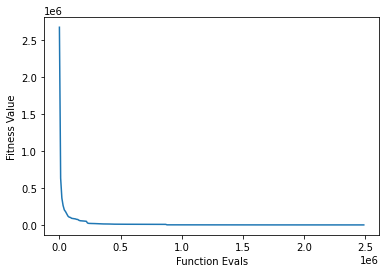

Best minimas of each run:
[-449.99981984 -449.99941306 -449.99924533 -449.99908402 -449.99891015
 -449.99864871 -449.99858545 -449.99839872 -449.99726805 -449.99603955
 -449.9927945  -449.98510231 -449.92829986 -449.59776292 -449.52995954
 -449.07716599 -448.21074377 -448.07475643 -443.05869494 -442.42772622
 -438.639977   -438.14818006 -429.31742632 -413.70310269 -384.39485277]
Params:, 500, 25000, 100, 0.7298, 2.5, 1.55, 0.5, 5, 1, True, 1
Time span: 267.155439
Best loss0.0001801568967039202


In [9]:
Run_Shifted_Sphere(params_sphere_500)

# Schwefel Problem

Schwefel problem is a unimodal function which means that it has a single minima which will be its local and global minima

### Choice of parameters
In case of Schwefel problem a large value of cognitive component as compared to the social component will be efficient as it will lead to intensification or exploitation for each particle and pulling it towards its best position. It causes the particles to move towards the only optima which is a good strategy for a unimodal problem. We are using gbest as the neighbourhood type so that causes the particle to converge faster. Max velocity is set to a low value of 0.05 as the minima is inside a narrow valley while inertia is set to its default values of 0.7298. 
    parameters = {   
        'eta1': 2.17,
        'eta2': 1.84,
        'max_vel': 0.05,
        'omega' : 0.7298,
    }
    
### Results Obtained
#### 50 dimensions
##### Parameters
We set 'population_size' to 50 and 'num_gen' to 5000
##### Results
For 50 dimensions we reached the function minimum of -450 which is the actual optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 250,000
##### Time Taken
 Using parallel architecture the time taken for reaching the minimum with 250,000 FES was 6 seconds
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges easily with lots of function evals left from Max_FES which is set to dimensions*5000 = 250,000. Please see the output below for the graph.
#### 500 dimensions
##### Parameters
We set 'population_size' to 100 so that we don't make the population unmanageable and 'number of generations' to 25000 so that we reach our MAX_FES value. We did 25 runs and this was the output of our best run.  
##### Results
For 500 dimensions we reached the minimum of -413 which has a loss of 37 from optima
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 2.5 million
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 2.5 million FES was 264 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges with more function evals as compared to 50 dimensions. Please see the output below for the graph.

In [10]:
params_schwefel_50 = {'eta1': 1.85,
        'eta2': 2.15,
        'max_vel': 0.05,
        'omega' : 0.7299,
        'dim' : 50,
        'population_size': 50,
        'num_gen' : 5000
    }


Problem name: Schwefel Problem CEC08
	C++ class name: pybind11::object

	Global dimension:			50
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-100, -100, -100, -100, -100, ... ]
	Upper bounds: [100, 100, 100, 100, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 50
[]


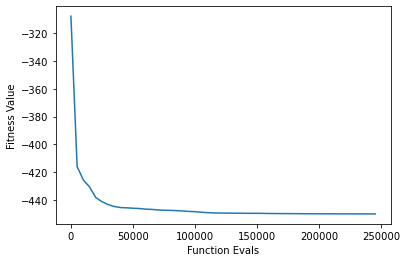

Best minimas of each run:
[-449.94593651 -449.93387846 -449.90593512 -449.89611117 -449.88952772
 -449.88144484 -449.85763275 -449.85619564 -449.85067429 -449.83671821
 -449.82223521 -449.79784219 -449.795199   -449.77932641 -449.77792266
 -449.77080995 -449.76279317 -449.74989219 -449.72698758 -449.61599835
 -449.6125345  -449.60139131 -449.54431209 -449.54336962 -449.49510697]
Params:, 50, 5000, 50, 0.7299, 1.85, 2.15, 0.05, 5, 1, True, 1
Time span: 7.850868
Best loss0.054063490472913145


In [11]:
Run_Schwefel_Problem(params_schwefel_50)

In [12]:
params_schwefel_500 = {'eta1': 2.17,
        'eta2': 1.84,
        'max_vel': 0.05,
        'omega' : 0.7299,
        'dim' : 500,
        'population_size': 100,
        'num_gen' : 25000
    }

Problem name: Schwefel Problem CEC08
	C++ class name: pybind11::object

	Global dimension:			500
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-100, -100, -100, -100, -100, ... ]
	Upper bounds: [100, 100, 100, 100, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 500
[]


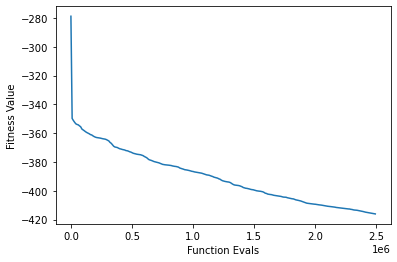

Best minimas of each run:
[-416.17840863 -413.19580847 -412.45766133 -412.02375809 -411.7917025
 -411.28972278 -411.08448372 -411.0012719  -410.49880533 -409.84843747
 -409.61221273 -409.25874525 -409.23966002 -408.92796621 -408.53777898
 -408.50678323 -408.08885776 -408.0749811  -408.0137376  -407.53311858
 -407.44404193 -407.37215748 -406.54676193 -406.45033866 -402.04048157]
Params:, 500, 25000, 100, 0.7299, 2.17, 1.84, 0.05, 5, 1, True, 1
Time span: 303.189919
Best loss33.82159136695685


In [13]:
Run_Schwefel_Problem(params_schwefel_500)

# Ackley

Ackley is a multi-modal function which means that it has multiple minimas one of which will be a global minima

### Choice of parameters
In case of Ackley function a large value of cognitive component as compared to the social component as this will be  a good strategy for getting the optima. A high value of cognitive component helps in reaching the global minima when we are near it. The social componenet helps in avoiding particles in getting trapped in local optima. Max FES was set to 5000 times dimension. Max velocity is set to a low value of 0.15 while Inertia is set to its default values of 0.7290. 
    parameters = {   
        'eta1': 2.65,
        'eta2': 1.76,
        'max_vel': 0.15,
        'omega' : 0.7290,
    }
    
### Results Obtained
#### 50 dimensions
##### Parameters
We set 'population_size' to 50 and 'num_gen' to 5000. 
##### Results
For 50 dimensions we reached the function minimum of -140 which is the actual optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 250,000
##### Time Taken
 Using parallel architecture the time taken for reaching the minimum with 250,000 FES was 7.2 seconds
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges easily with lots of function evals left from Max_FES which is set to dimensions*5000 = 250,000. Please see the output below for the graph.

#### 500 dimensions
##### Parameters
We set 'population_size' to 100 so that we don't make the population unmanageable and 'number of generations' to 25000 so that we reach our MAX_FES value.
##### Results
For 500 dimensions we reached the minimum of -136 which has a loss of 4 from optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 2.5 million
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 2.5 million FES was 344 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges with more function evals as compared to 50 dimensions. Please see the output below for the graph.

In [14]:
params_ackley_50 = {'eta1': 2.65,
        'eta2': 1.76,
        'max_vel': 0.15,
        'omega' : 0.7290,
        'dim' : 50,
        'population_size': 50,
        'num_gen' : 5000
    }

Problem name: Shifted Ackley CEC08
	C++ class name: pybind11::object

	Global dimension:			50
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-32, -32, -32, -32, -32, ... ]
	Upper bounds: [32, 32, 32, 32, 32, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 50
[]


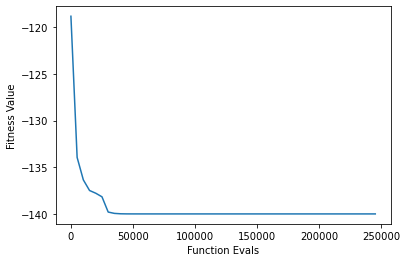

Best minimas of each run:
[-140.         -140.         -140.         -140.         -140.
 -140.         -140.         -140.         -138.8448515  -138.73025235
 -138.73025235 -138.73025235 -138.62568788 -138.62568788 -138.35377637
 -138.35377637 -138.27338255 -138.27338255 -138.19691999 -138.19691999
 -138.19691999 -138.12390085 -137.51043318 -137.09937923 -120.97820921]
Params:, 50, 5000, 50, 0.729, 2.65, 1.76, 0.15, 5, 1, True, 1
Time span: 8.728548
Best loss5.684341886080802e-14


In [15]:
Run_Ackley(params_ackley_50)

In [16]:
params_ackley_500 = {'eta1': 2.65,
        'eta2': 1.76,
        'max_vel': 0.15,
        'omega' : 0.7290,
        'dim' : 500,
        'population_size': 100,
        'num_gen' : 25000
    }


Problem name: Shifted Ackley CEC08
	C++ class name: pybind11::object

	Global dimension:			500
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-32, -32, -32, -32, -32, ... ]
	Upper bounds: [32, 32, 32, 32, 32, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 500
[]


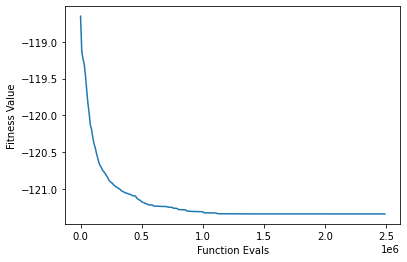

Best minimas of each run:
[-121.33902295 -121.17901669 -121.03103597 -120.99310255 -120.97893566
 -120.921639   -120.87314045 -120.8730576  -120.86569345 -120.84331918
 -120.83048399 -120.82751208 -120.82329125 -120.81038282 -120.80260565
 -120.80201532 -120.788135   -120.78410448 -120.77610479 -120.76572379
 -120.75332279 -120.7378286  -120.65869259 -120.6575456  -120.63630208]
Params:, 500, 25000, 100, 0.729, 2.65, 1.76, 0.15, 5, 1, True, 1
Time span: 405.678094
Best loss18.660977051881986


In [17]:
Run_Ackley(params_ackley_500)

# Shifted Griewank

Shifted Griewank is multi-modal function which means that it has may have multiple minimas one of which will be a global minima

### Choice of parameters
In case of shifted griewank a large value of cognitive component as compared to the social component will be efficient as it will cause intensificaton causing particles to move towards the optima. The social compnent helps in avoiding particles in getting trapped in local minimas. Max FES was set to 5000 times dimension. Max velocity is set to a low value of 0.28 while Inertia is set to a value of 0.7215. We use gbest PSO which reflects a star topology as we want the particles to learn from the entire swarm. 
    parameters = 
    {   
        'eta1': 2.2,
        'eta2': 1.9,
        'max_vel': 0.28,
        'omega' : 0.7215,
    }
    
### Results Obtained
#### 50 dimensions
##### Parameters
We set 'population_size' to 50 and 'num_gen' to 5000
##### Results
For 50 dimensions we reached the function minimum of -180 which is the actual optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 250,000
##### Time Taken
 Using parallel architecture the time taken for reaching the minimum with 250,000 FES was 6.5 seconds
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges easily with lots of function evals left from Max_FES which is set to dimensions*5000 = 250,000. Please see the output below for the graph.
#### 500 dimensions
##### Parameters
We set 'population_size' to 100 so that we don't make the population unmanageable and 'number of generations' to 25000 so that we reach our MAX_FES value.   
##### Results
For 500 dimensions we reached the minimum of -180 which is the optima. We did 25 runs and this was the output of our best run.
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 2.5 million
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 2.5 million FES was 326 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges with more function evals as compared to 50 dimensions. Please see the output below for the graph.

In [18]:

params_griewank_50 ={'eta1': 2.2,
        'eta2': 1.9,
        'max_vel': 0.28,
        'omega' : 0.7215,
        'dim' : 50,
        'population_size': 50,
        'num_gen' : 5000
    }


Problem name: Shifted Griewank CEC08
	C++ class name: pybind11::object

	Global dimension:			50
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-600, -600, -600, -600, -600, ... ]
	Upper bounds: [600, 600, 600, 600, 600, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 50
[]


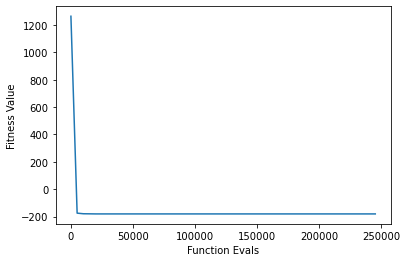

Best minimas of each run:
[-180.         -180.         -180.         -180.         -180.
 -179.99260396 -179.99014272 -179.98767901 -179.97540956 -179.92221211
 -179.92135775 -179.91728717 -179.89785054 -179.8960352  -179.8657579
 -179.83618651 -179.83504502 -179.82545457 -179.82393215 -179.6966638
 -179.34992837 -178.88029212 -178.64189366 -178.50270451 -170.88274719]
Params:, 50, 5000, 50, 0.7215, 2.2, 1.9, 0.28, 5, 1, True, 1
Time span: 8.224064
Best loss2.842170943040401e-14


In [19]:
Run_Griewank(params_griewank_50)

In [20]:
params_griewank_500 ={'eta1': 2.2,
        'eta2': 1.9,
        'max_vel': 0.28,
        'omega' : 0.7215,
        'dim' : 500,
        'population_size': 100,
        'num_gen' : 25000
    }


Problem name: Shifted Griewank CEC08
	C++ class name: pybind11::object

	Global dimension:			500
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-600, -600, -600, -600, -600, ... ]
	Upper bounds: [600, 600, 600, 600, 600, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 500
[]


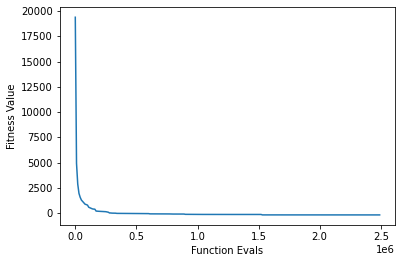

Best minimas of each run:
[-179.99995966 -179.99995792 -179.99957843 -179.9992766  -179.99473829
 -179.96556181 -179.66846488 -179.59552904 -179.50784345 -179.45193431
 -179.15897328 -179.12742149 -178.96302337 -178.93696488 -178.90874921
 -178.90635657 -178.56321726 -178.46100447 -178.43944363 -178.08008838
 -177.44831429 -177.42584652 -177.13851248 -169.02259083 -166.76919414]
Params:, 500, 25000, 100, 0.7215, 2.2, 1.9, 0.28, 5, 1, True, 1
Time span: 399.324117
Best loss4.0343296973333054e-05


In [21]:
Run_Griewank(params_griewank_500)

# Shifted Rastrigin

Shifted Rastrigin is multi-modal function which means that it has may have multiple minimas one of which will be a global minima

### Choice of parameters
In case of shifted rastrigin there are a very large number of local minimas so a large value of social component as compared to the cognitive component will be efficient as it will pull the swarm towards the global best position causing particles to escape local minimas. The cognitive component helps in reaching the optimas using intensification. Max FES was set to 5000 times dimension. Max velocity is set to a low value of 0.3 while inertia is set to a value of 0.7295. 
    parameters = 
    {   
        'eta1': 1.9,
        'eta2': 2.9,
        'max_vel': 0.3,
        'omega' : 0.7295    
    }
    
### Results Obtained
#### 50 dimensions
##### Parameters
We set 'population_size' to 50 and 'num_gen' to 5000
##### Results
For 50 dimensions we reached the function minimum of -294 which has a loss of 36 from the actual optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 250,000
##### Time Taken
 Using parallel architecture the time taken for reaching the minimum with 250,000 FES was 6.8 seconds
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges easily with lots of function evals left from Max_FES which is set to dimensions*5000 = 250,000. Please see the output below for the graph.
#### 500 dimensions
##### Parameters
We set 'population_size' to 100 so that we don't make the population unmanageable and 'number of generations' to 25000 so that we reach our MAX_FES value.   
##### Results
For 500 dimensions we reached the minimum of 1816 which has a loss of 2146 from the optima. We did 25 runs and this was the output of our best run.
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 2.5 million
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 2.5 million FES was 326 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges with more function evals as compared to 50 dimensions. Please see the output below for the graph.

In [22]:

params_rastrigin_50 ={'eta1': 1.9,
        'eta2': 2.9,
        'max_vel': 0.3,
        'omega' : 0.7295,
        'dim' : 50,
        'population_size': 100,
        'num_gen' : 2500
    }


Problem name: Shifted Rastrigin CEC08
	C++ class name: pybind11::object

	Global dimension:			50
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5, -5, -5, -5, ... ]
	Upper bounds: [5, 5, 5, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 50
[]


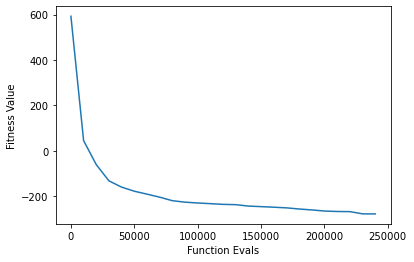

Best minimas of each run:
[-281.64946042 -278.30004532 -263.09627854 -257.68328251 -257.32437432
 -254.1030165  -253.68223059 -253.49607571 -250.9059616  -249.86974813
 -247.8523096  -247.66200346 -246.91922893 -243.49227464 -243.42856501
 -241.92801318 -240.85640623 -239.15567664 -237.78358074 -235.60025069
 -229.19917049 -224.82801103 -207.29154283 -197.88411662 -184.27674037]
Params:, 50, 2500, 100, 0.7295, 1.9, 2.9, 0.3, 5, 1, True, 1
Time span: 8.375382
Best loss48.35053958428546


In [23]:
Run_Rastrigin(params_rastrigin_50)

In [24]:
params_rastrigin_500 ={'eta1': 1.9,
        'eta2': 2.9,
        'max_vel': 0.3,
        'omega' : 0.7295,
        'dim' : 500,
        'population_size': 100,
        'num_gen' : 25000
    }


Problem name: Shifted Rastrigin CEC08
	C++ class name: pybind11::object

	Global dimension:			500
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5, -5, -5, -5, ... ]
	Upper bounds: [5, 5, 5, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 500
[]


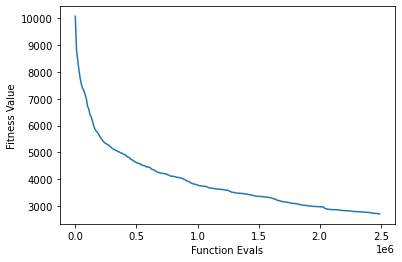

Best minimas of each run:
[2706.91636801 2711.56720143 2716.93076181 2720.91084264 2739.22537151
 2751.60544945 2799.04038353 2846.80326038 2869.40544623 2937.06080032
 2955.59170415 2975.57003942 2977.36580496 2994.09534611 3003.83751726
 3050.38749438 3064.07076661 3070.72931872 3074.42958584 3084.47792776
 3126.84611727 3138.92579973 3190.65513946 3305.4604744  3371.99219323]
Params:, 500, 25000, 100, 0.7295, 1.9, 2.9, 0.3, 5, 1, True, 1
Time span: 440.866549
Best loss3036.916368005407


In [25]:
Run_Rastrigin(params_rastrigin_500)

# Shifted Rosenbrock

Shifted Rosenborck is multi-modal function which means that it has may have multiple minimas one of which will be a global minima

### Choice of parameters
In case of shifted Rosenbrock a larger value of cognitive component as compared to the social component will be efficient as when we are near the global minima intensification will allow the particles to go down deep towards minima. A not so small value of social component helps particles escape from being trapped in the local minims. Max FES was set to 5000 times dimension. Max velocity is set to a low value of 0.1 as the global minima is a narrow valley which means we do not want go over it, while inertia is set to a value of 0.7295. 
    parameters = 
    {   
        'eta1':2.22,
        'eta2': 1.93,
        'max_vel': 0.1,
        'omega' : 0.7293    
    }
    
### Results Obtained
#### 50 dimensions
##### Parameters
We set 'population_size' to 50 and 'num_gen' to 5000
##### Results
For 50 dimensions we reached the function minimum of 390 which the actual optima. We did 25 runs and this was the output of our best run.  
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 250,000
##### Time Taken
 Using parallel architecture the time taken for reaching the minimum with 250,000 FES was 7.8 seconds
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges easily with lots of function evals left from Max_FES which is set to dimensions*5000 = 250,000. Please see the output below for the graph.
#### 500 dimensions
##### Parameters
We set 'population_size' to 100 so that we don't make the population unmanageable and 'number of generations' to 25000 so that we reach our MAX_FES value.   
##### Results
For 500 dimensions we reached the minimum of 1452 which has a loss of 1062 from the optima. We did 25 runs and this was the output of our best run.
##### Stopping Criteria
We use execution till MAX_FES as the stopping criteria. It is set to dimensions*5000 = 2.5 million
##### Time Taken
Using parallel architecture the time taken for reaching the minimum with 2.5 million FES was 314 seconds.
##### Convergence Curve
The fitness vs FES convergence curve, for champion run,  converges with more function evals as compared to 50 dimensions. Please see the output below for the graph.

In [26]:
params_rosenbrock_50 ={'eta1':2.22,
        'eta2': 1.93,
        'max_vel': 0.1,
        'omega' : 0.7295,
        'dim' : 50,
        'population_size': 50,
        'num_gen' : 5000
    }


Problem name: Shifted Rosenbrock CEC08
	C++ class name: pybind11::object

	Global dimension:			50
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-100, -100, -100, -100, -100, ... ]
	Upper bounds: [100, 100, 100, 100, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 50
[]


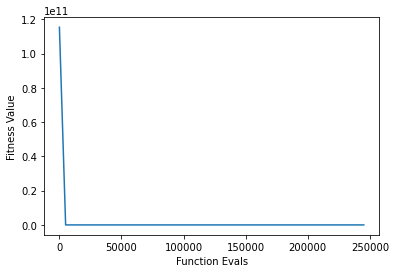

Best minimas of each run:
[3.94042009e+02 4.01903685e+02 4.09529245e+02 4.12718233e+02
 4.13869965e+02 4.18190524e+02 4.23179880e+02 4.23833306e+02
 4.25434683e+02 4.25853232e+02 4.26478969e+02 4.26506495e+02
 4.27485492e+02 4.31619242e+02 4.63461730e+02 4.66633698e+02
 4.67706063e+02 4.67726546e+02 4.70745000e+02 4.71495340e+02
 4.72588970e+02 4.74734517e+02 4.75505272e+02 4.77403562e+02
 1.20643723e+07]
Params:, 50, 5000, 50, 0.7295, 2.22, 1.93, 0.1, 5, 1, True, 1
Time span: 7.413903
Best loss4.0420094546404925


In [27]:
Run_Rosenbrock(params_rosenbrock_50)

In [28]:
params_rosenbrock_500 ={'eta1':2.22,
        'eta2': 1.93,
        'max_vel': 0.1,
        'omega' : 0.7295,
        'dim' : 500,
        'population_size': 100,
        'num_gen' : 25000
    }

Problem name: Shifted Rosenbrock CEC08
	C++ class name: pybind11::object

	Global dimension:			500
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-100, -100, -100, -100, -100, ... ]
	Upper bounds: [100, 100, 100, 100, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 500
[]


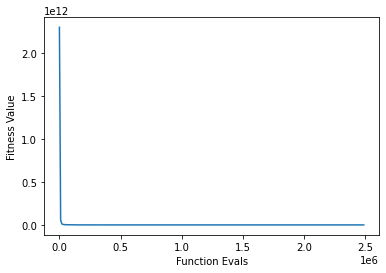

Best minimas of each run:
[  1391.77086809   1451.2507846    1538.98357525   1547.52923735
   1563.94554225   1635.61599885   1705.00098592   1708.7878941
   1729.8436874    1748.47687057   1776.79516019   1817.9196702
   1894.13825563   1994.78548979   2504.15859919   2603.75305199
   2716.39791914   2897.1625636    3829.23442674   4660.86357129
   4877.4231344   11289.79155349 739144.11482438 739305.48217828
 739332.0483628 ]
Params:, 500, 25000, 100, 0.7295, 2.22, 1.93, 0.1, 5, 1, True, 1
Time span: 334.2944
Best loss1001.7708680879359


In [29]:
Run_Rosenbrock(params_rosenbrock_500)